## Discrete-time competitive Beverton-Holt model

\begin{align}
N_{1,t+1}=\dfrac{r_1N_{1,t}}{1+a_{11}N_{1,t}+a_{12}N_{2,t}} \\
N_{2,t+1}=\dfrac{r_2N_{2,t}}{1+a_{22}N_{2,t}+a_{21}N_{1,t}}
\tag{1}
\end{align}

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import jit
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('onedork') #grade3

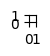

In [2]:
# Dummy plot
fig, ax = plt.subplots(figsize=(0.1, 0.1))
ax.axhline(y=1, color='grey', linestyle='-')
plt.rcParams.update({'font.size': 30})

In [3]:
step=5

In [4]:
def getPCG(r1,r2,a11,a22,a12,a21,N1,N2):
    newN = np.zeros(2)
    newN[0] = r1 * N1 / (1 + a11 * N1 + a12 * N2)
    newN[1] = r2 * N2 / (1 + a21 * N1 + a22 * N2)
    out = np.zeros(2)
    out[0] = np.log(newN[0]) - np.log(N1)  # per capita growth rate of species 1
    out[1] = np.log(newN[1]) - np.log(N2)  # per capita growth rate of species 2
    return out

In [5]:
def getEqDensity(fixed_species,r1,r2,a11,a22,a12,a21,N_star):
    if fixed_species == 1:
        # density of species one is known
        out = (r2 - 1 - a21 * N_star) / a22
    elif fixed_species == 2:
        # density of species two is known
        out = (r1 - 1 - a12 * N_star) / a11
    return out

In [6]:
def calculate_frequency(N_focal, N_other):
    freq = N_focal / (N_focal + N_other)
    return freq

In [7]:
def calculate_CE(r1,r2,a11,a22,a12,a21):
    C12 = (r1 - 1) / a12 - (1 / a22) * (r2 - 1)
    C21 = (r2 - 1) / a21 - (1 / a11) * (r1 - 1)
    if C12 == 0 and C21 == 0:
        return 'local_coexistence', C12, C21 # C12=C21=0
    elif C12 * C21 < 0:
        return 'global_competitive_exclusion', C12, C21 # C12 C21 < 0
    elif C12 < 0 and C21 < 0:
        return 'local_competitive_exclusion', C12, C21 # C12, C21 < 0
    elif C12 > 0 and C21 > 0:
        return 'global_coexistence', C12, C21 # C12, C21 > 0
    elif C12 == 0 or C21 == 0:
        return 'undefined', C12, C21 # C12=C21=0
    else:
        return 'error', C12, C21

In [8]:
def getNFD(r1,r2,a11,a22,a12,a21, lowN, deltaN):
    # lowN is the low density 
    # and deltaN is the increase in N for the higher density to explore

    # vectors for output
    pgr1, freq1, pgr2, freq2 = np.zeros(2), np.zeros(2), np.zeros(2), np.zeros(2)

    # get low density growth rate for spp 1
    tmpN = np.zeros(2)
    tmpN = np.zeros(2)
    tmpN[0] = lowN  # set density of focal spp
    tmpN[1] = getEqDensity(1, r1, r2, a11, a22, a12, a21, N_star=tmpN[0])  # figure out density of its competitor
    tmpOut = getPCG(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr1[0] = tmpOut[0]
#    freq1[0] = tmpN[0] / np.sum(tmpN)
    freq1[0] = calculate_frequency(tmpN[0], tmpN[1])
    sp2_low1 = tmpN[1]

    # get low density growth rate for spp 2
    tmpN = np.zeros(2)
    tmpN[1] = lowN
    tmpN[0] = getEqDensity(2, r1, r2, a11, a22, a12, a21, N_star=tmpN[1])
    tmpOut = getPCG(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr1[1] = tmpOut[1]
#     freq1[1] = tmpN[1] / np.sum(tmpN)
    freq1[1] = calculate_frequency(tmpN[1], tmpN[0])
    sp1_low2 = tmpN[0]

    # get higher density growth rate for spp1 1
    tmpN = np.zeros(2)
    tmpN[0] = lowN + deltaN
    tmpN[1] = getEqDensity(1, r1, r2, a11, a22, a12, a21, N_star=tmpN[0])
    tmpOut = getPCG(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr2[0] = tmpOut[0]
#     freq2[0] = tmpN[0] / np.sum(tmpN)
    freq2[0] =  calculate_frequency(tmpN[0], tmpN[1])
    sp2_high1 = tmpN[1]

    # get higher density growth rate for spp1 2
    tmpN = np.zeros(2)
    tmpN[1] = lowN + deltaN
    tmpN[0] = getEqDensity(2, r1, r2, a11, a22, a12, a21, N_star=tmpN[1])
    tmpOut = getPCG(r1, r2, a11, a22, a12, a21, tmpN[0], tmpN[1])
    pgr2[1] = tmpOut[1]
#     freq2[1] = tmpN[1] / np.sum(tmpN)
    freq2[1] = calculate_frequency(tmpN[1], tmpN[0])
    sp1_high2 = tmpN[0]

    out = {
        "pgr1": pgr1,
        "freq1": freq1,
        "pgr2": pgr2,
        "freq2": freq2
    }
    return out,sp2_low1,sp1_low2,sp2_high1,sp1_high2

In [9]:
def start_above_zero(pgr1, pgr2):
    above_zero = pgr1 > 0 and pgr2 > 0
    if above_zero:
        return 1
    else:
        return 0

In [10]:
def check_intercept(x1, y1, x2, y2):
    """Checks if two line segments intercept.

    Args:
        x1 (tuple): Tuple containing the x-coordinates of the endpoints of the first line segment.
        y1 (tuple): Tuple containing the y-coordinates of the endpoints of the first line segment.
        x2 (tuple): Tuple containing the x-coordinates of the endpoints of the second line segment.
        y2 (tuple): Tuple containing the y-coordinates of the endpoints of the second line segment.

    Returns:
        bool: 1 if the line segments intercept, 0 otherwise.
    """
    x_diff_1 = x1[1] - x1[0]
    y_diff_1 = y1[1] - y1[0]
    x_diff_2 = x2[1] - x2[0]
    y_diff_2 = y2[1] - y2[0]
    div = (y_diff_2 * x_diff_1) - (x_diff_2 * y_diff_1)

    if div == 0:
        return 0

    ua = ((x_diff_2 * (y1[0] - y2[0])) - (y_diff_2 * (x1[0] - x2[0]))) / div
    ub = ((x_diff_1 * (y1[0] - y2[0])) - (y_diff_1 * (x1[0] - x2[0]))) / div

    if 0 <= ua <= 1 and 0 <= ub <= 1:
        return 1

    return 0

In [11]:
def check_slope_no_intercept(x1, y1, x2, y2):
    """Checks if two line segments do not intercept and the upper line has a larger slope than the lower line.

    Args:
        x1 (tuple): Tuple containing the x-coordinates of the endpoints of the first line segment.
        y1 (tuple): Tuple containing the y-coordinates of the endpoints of the first line segment.
        x2 (tuple): Tuple containing the x-coordinates of the endpoints of the second line segment.
        y2 (tuple): Tuple containing the y-coordinates of the endpoints of the second line segment.

    Returns:
        bool: 1 if the lines don't intercept and the upper line has a larger slope, 0 otherwise.
    """
    # Check if lines don't intercept
    if check_intercept(x1, y1, x2, y2) == 0 and start_above_zero(y1[0], y2[0]) == 1:
        # Calculate the slopes of the lines
        slope_1 = (y1[1] - y1[0]) / (x1[1] - x1[0])
        slope_2 = (y2[1] - y2[0]) / (x2[1] - x2[0])

        # Check if one line is above the other and has a larger slope
        if y1[0] > y2[0] and slope_1 < slope_2:
            return 1
        elif y2[0] > y1[0] and slope_2 < slope_1:
            return 1
        else:
            return 0
    else:
        return 0

/tmp/ipykernel_42962/4228329528.py:7: RuntimeWarning: invalid value encountered in log
  out[1] = np.log(newN[1]) - np.log(N2)  # per capita growth rate of species 2
/tmp/ipykernel_42962/4228329528.py:6: RuntimeWarning: invalid value encountered in log
  out[0] = np.log(newN[0]) - np.log(N1)  # per capita growth rate of species 1


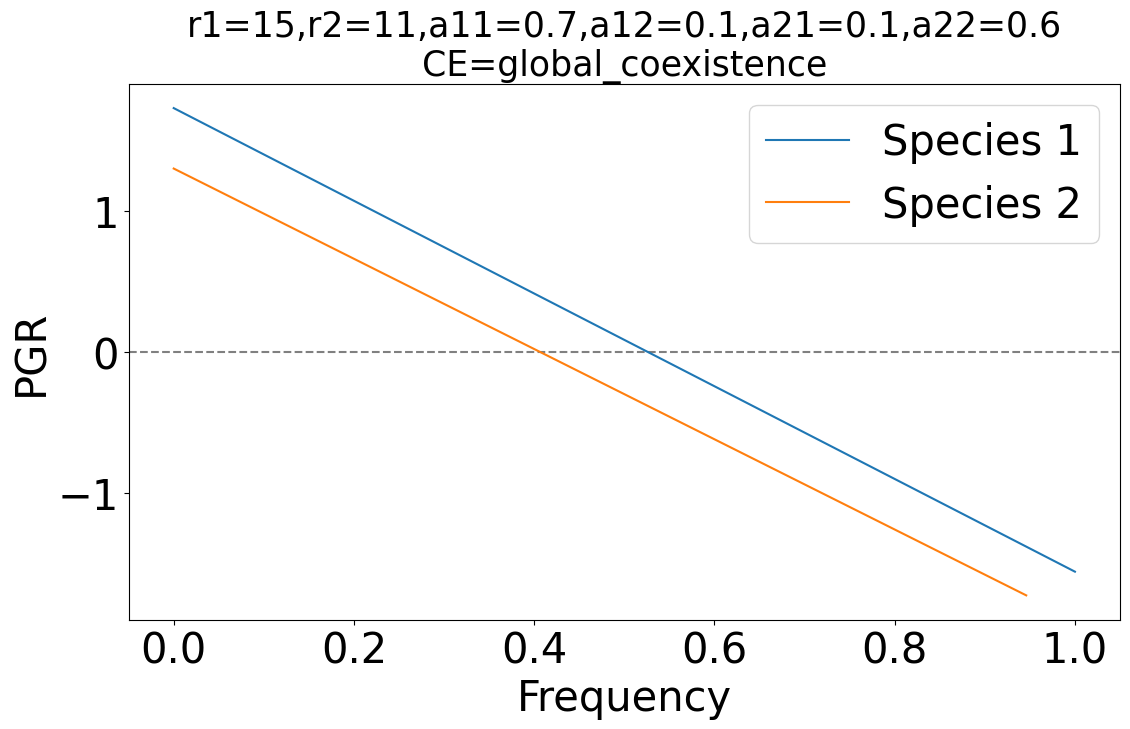

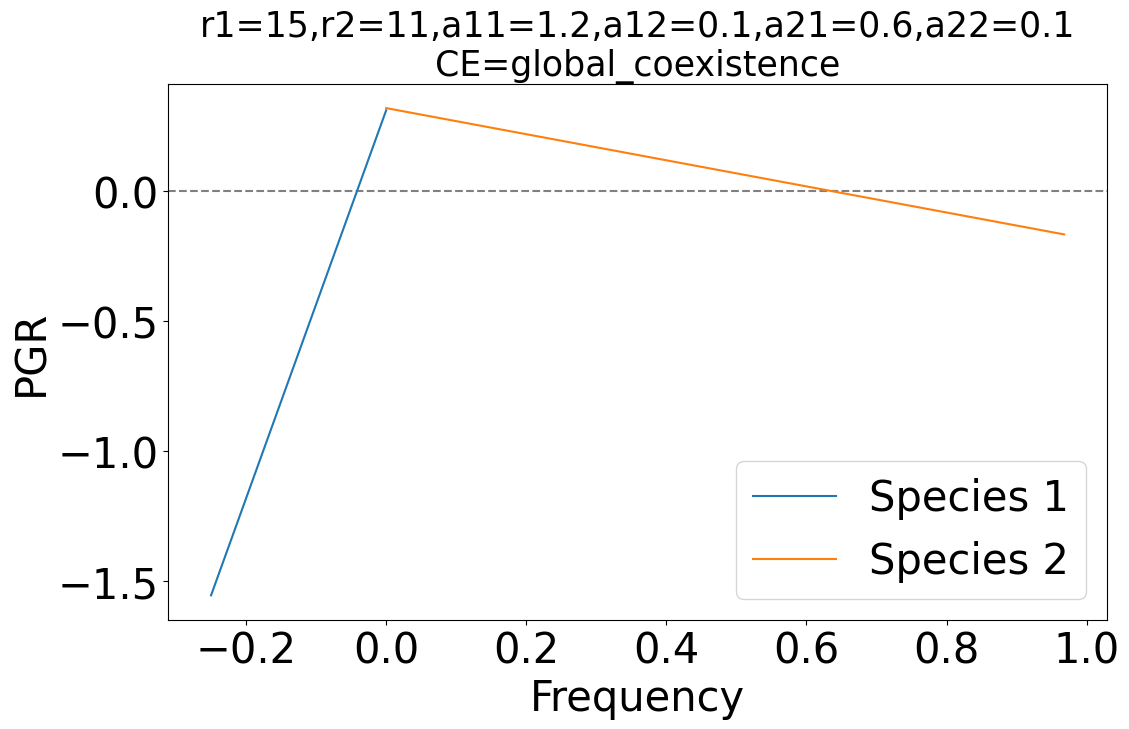

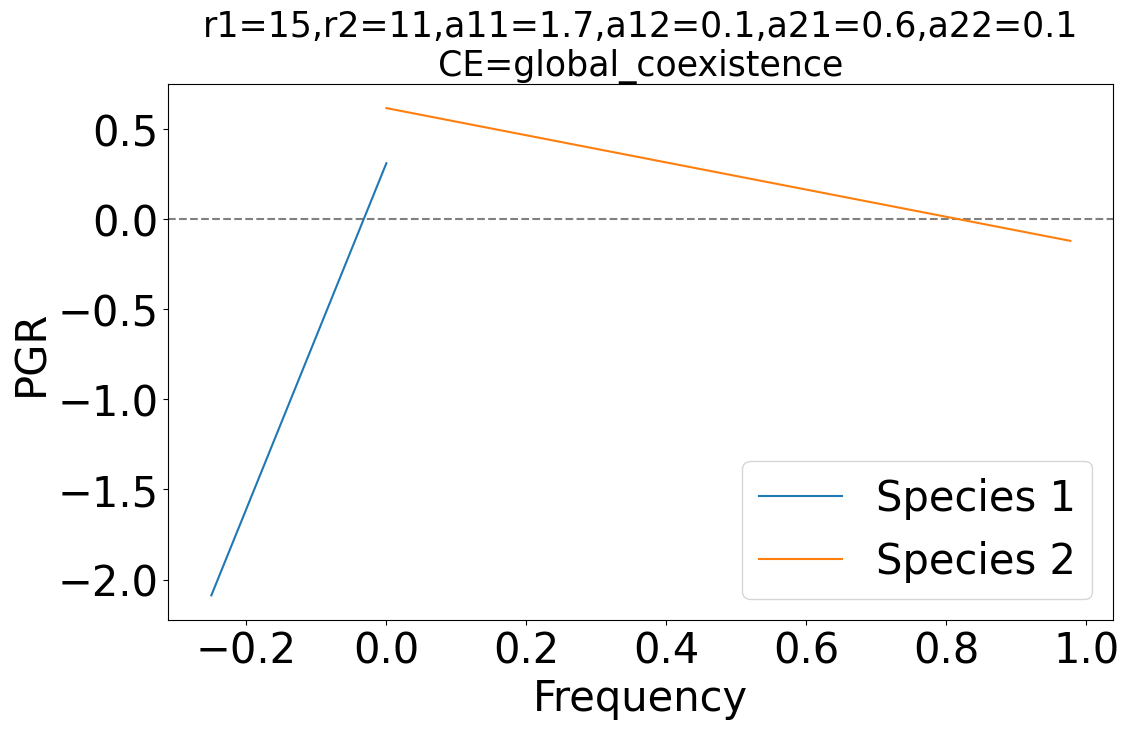

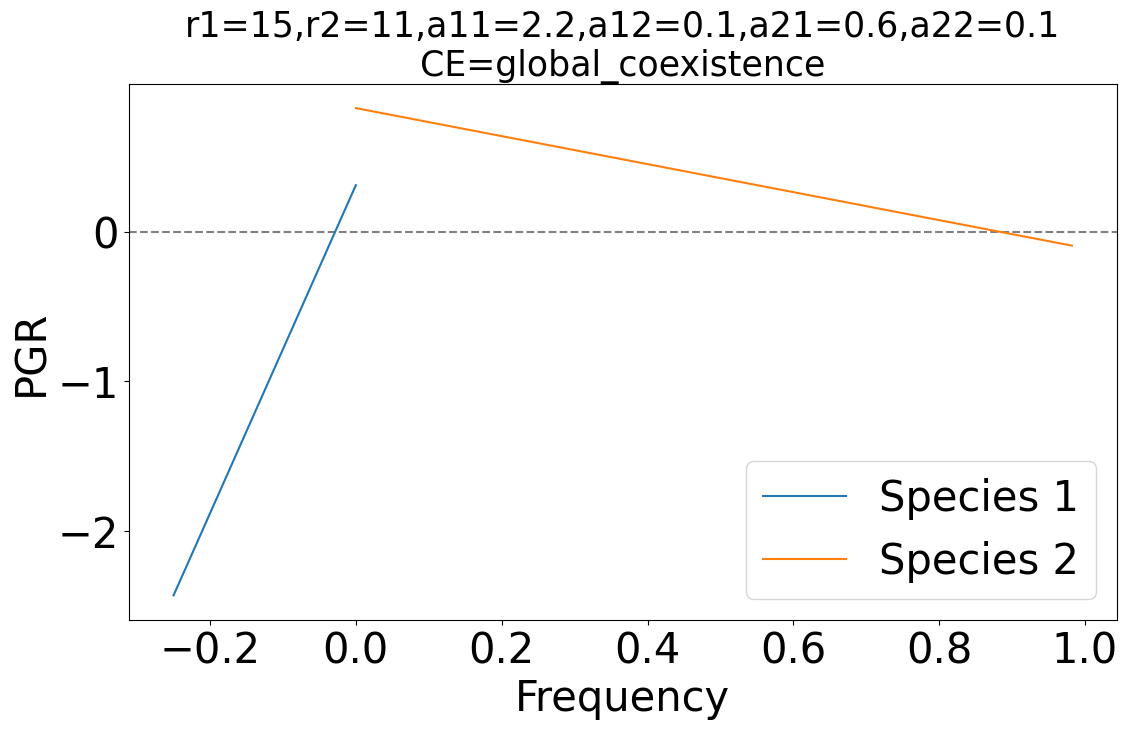

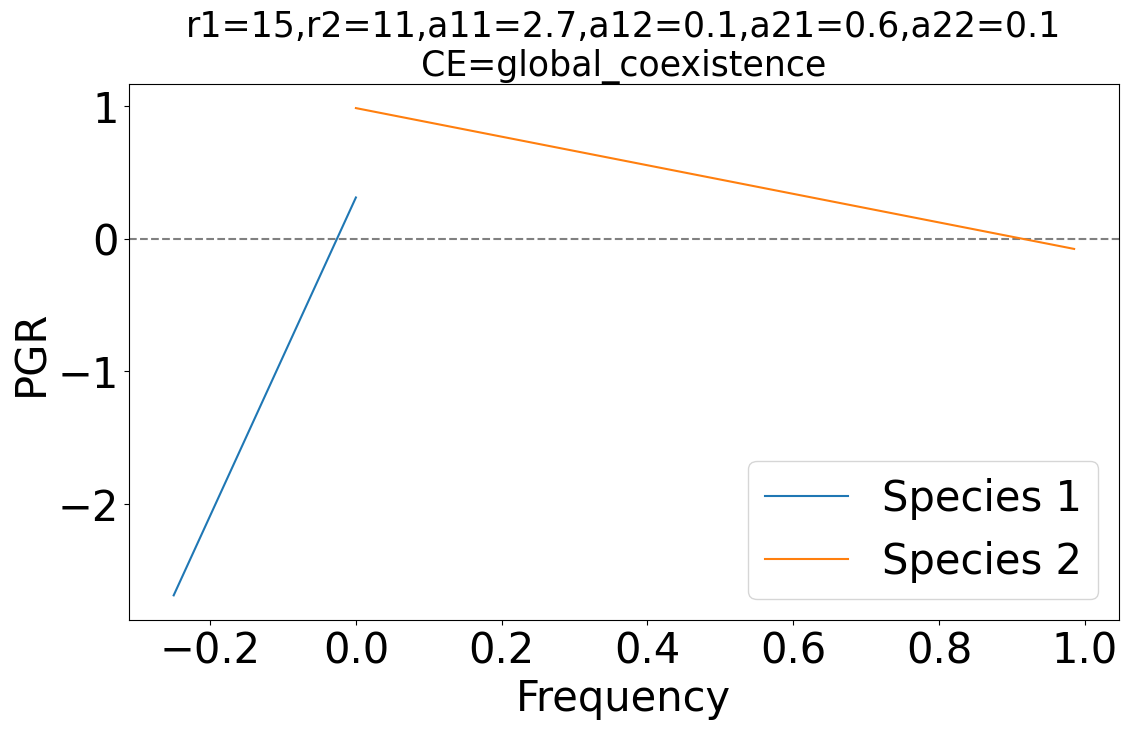

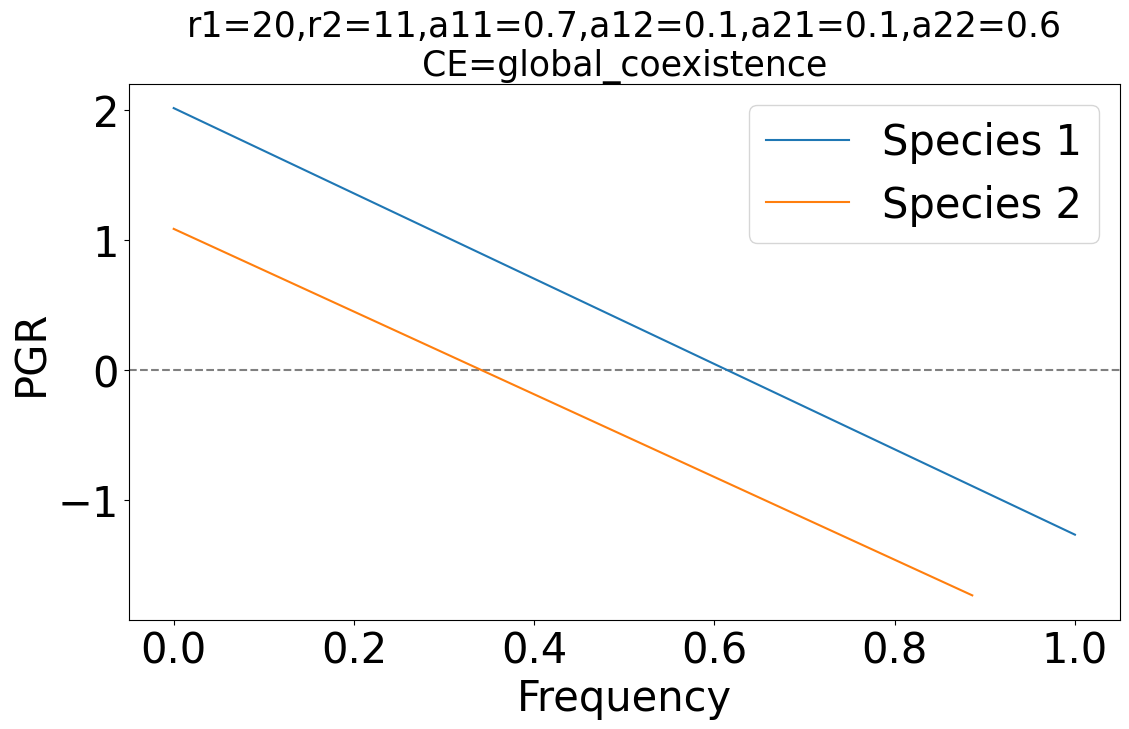

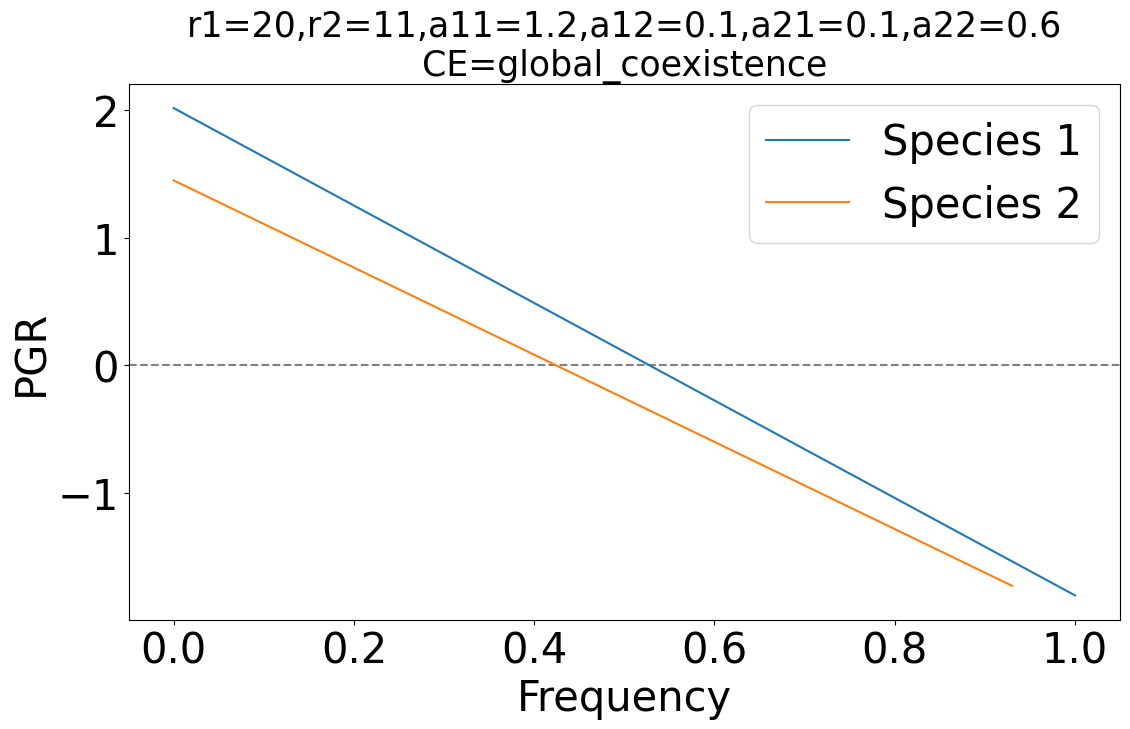

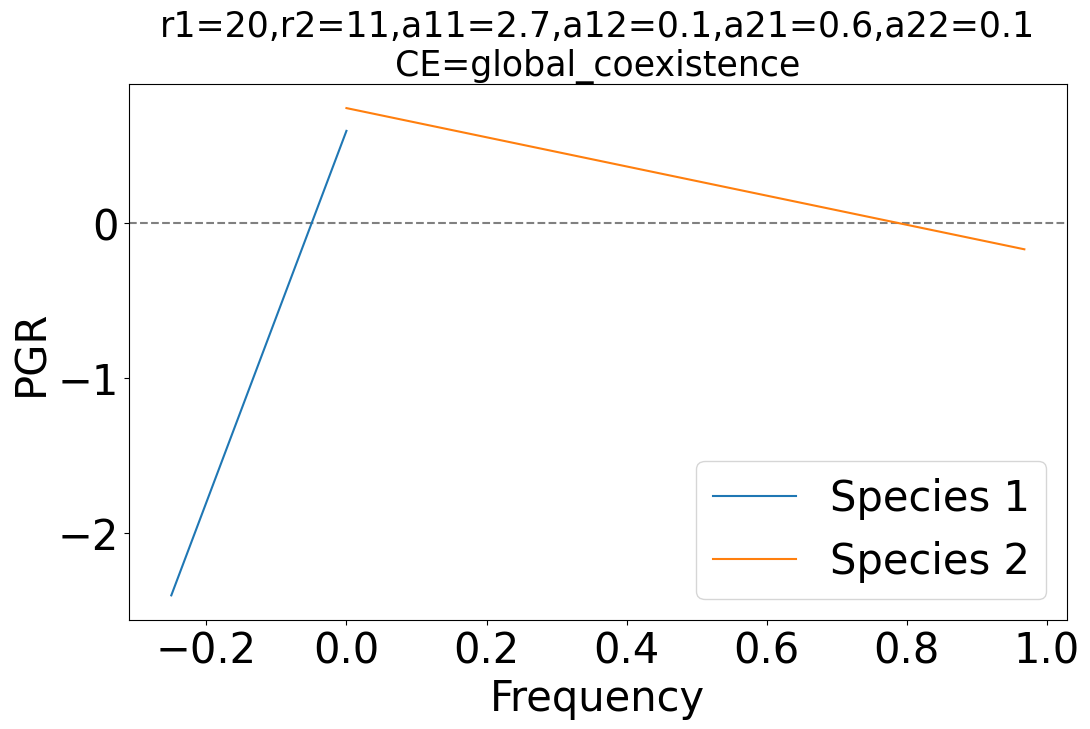

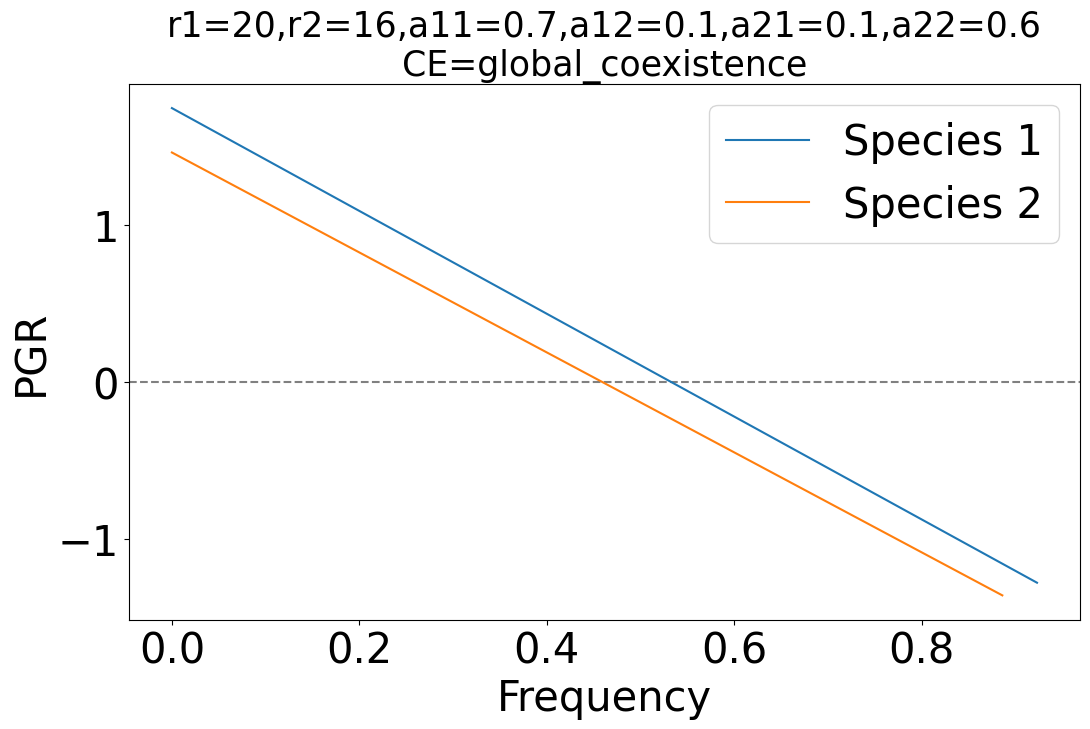

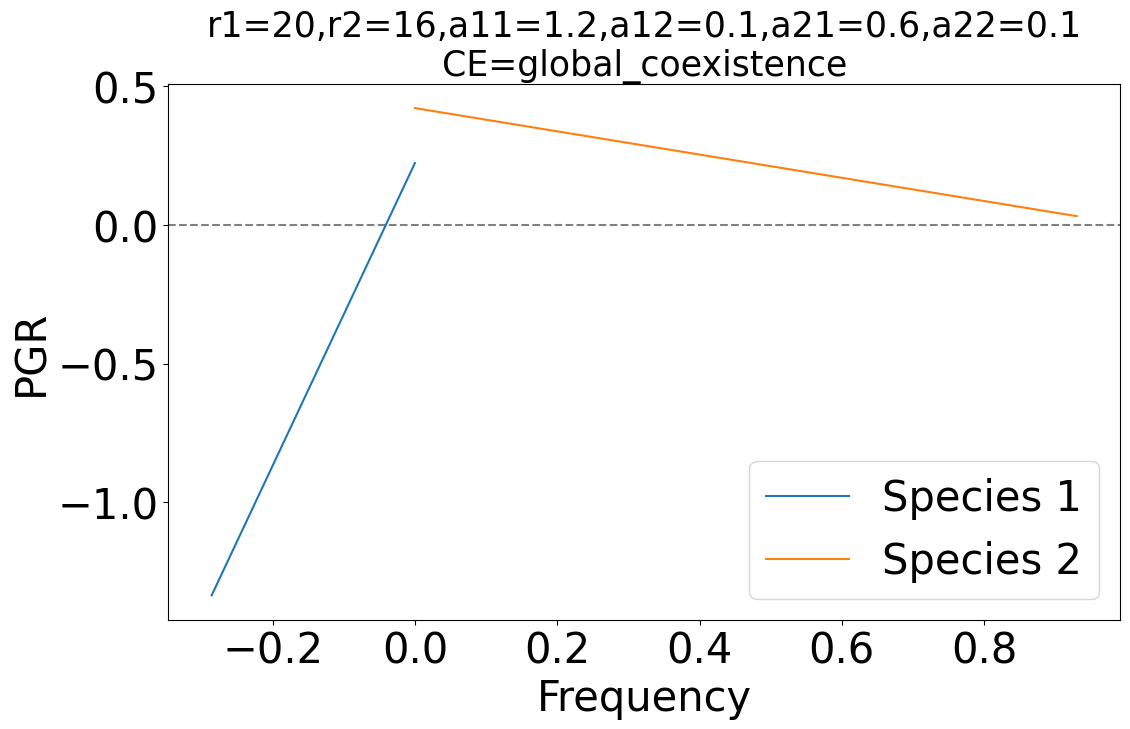

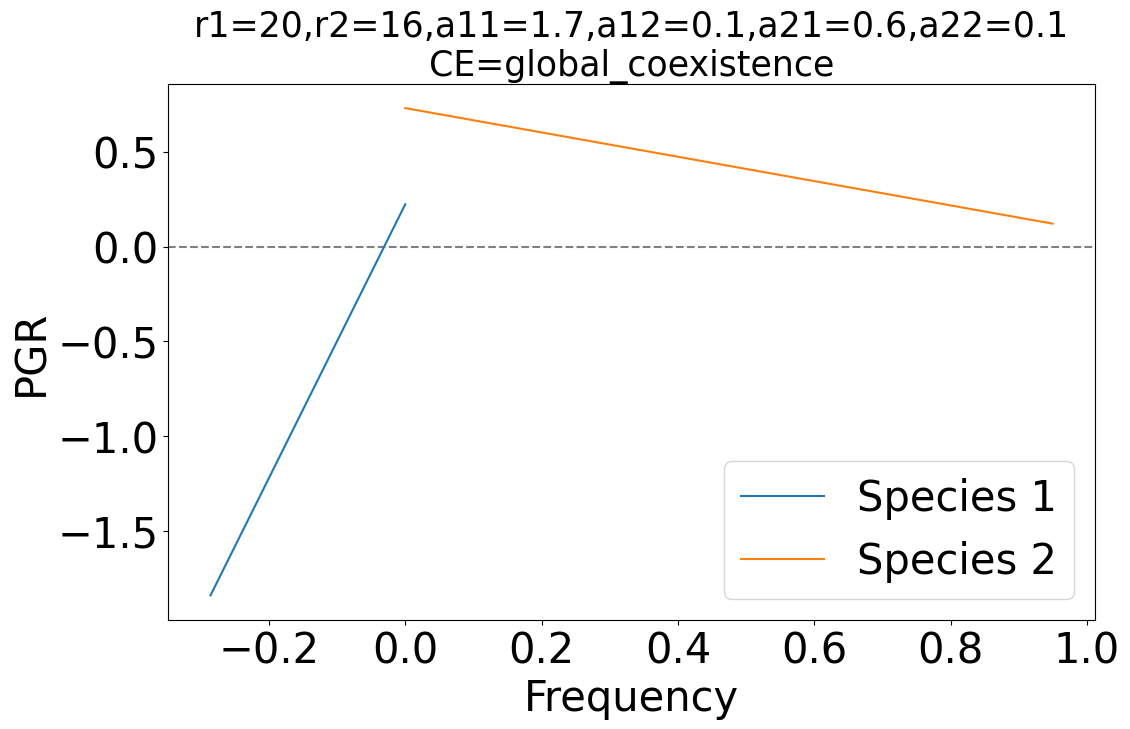

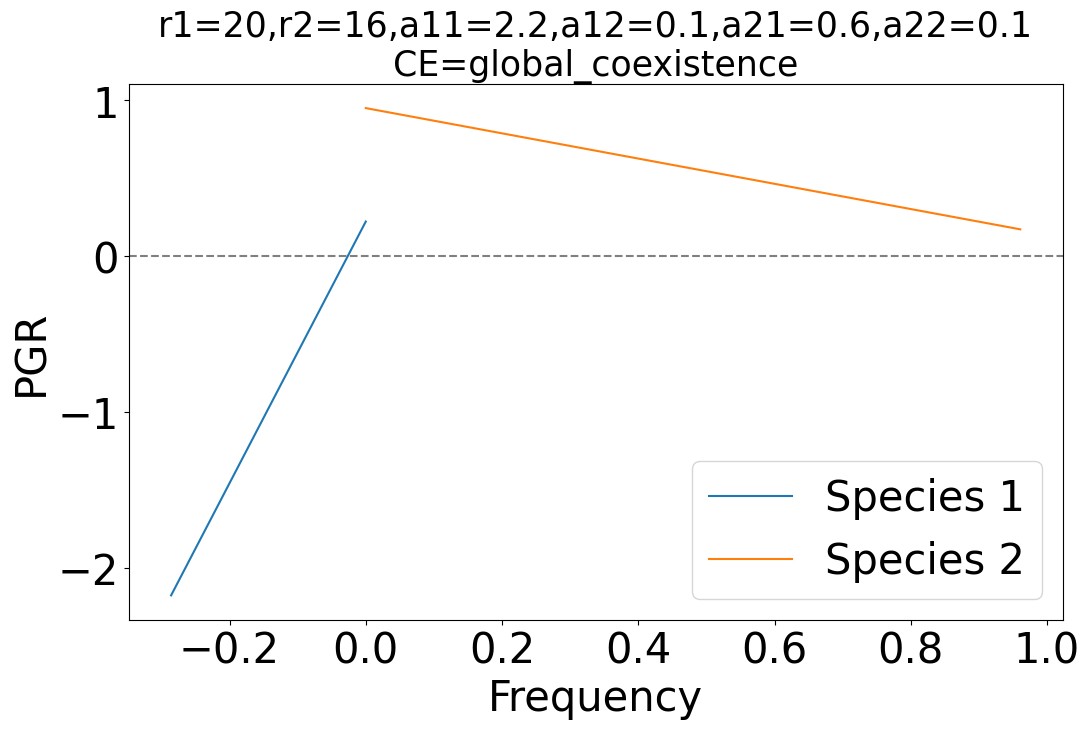

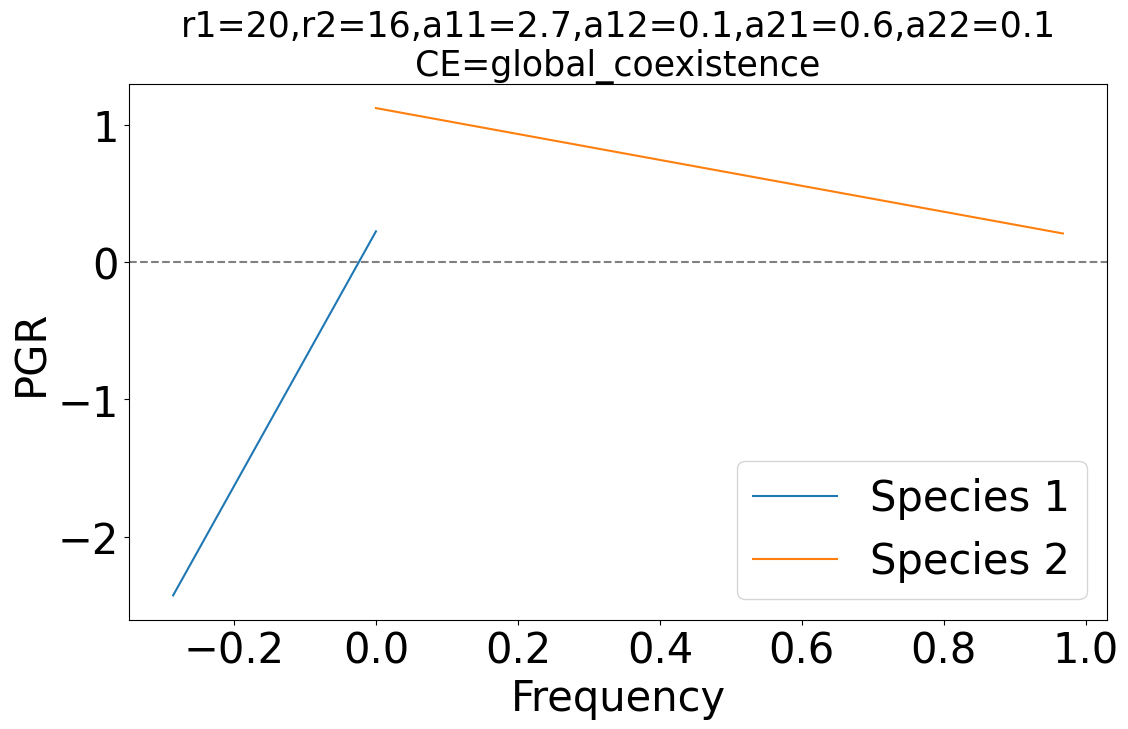

In [12]:
lowN = 0.0001
deltaN = 100
sp2_low1,sp1_low2,sp2_high1,sp1_high2=0.0,0.0,0.0,0.0
df=open('output.txt','w')
df.write("r1" + "\t" + "r2" + "\t" + "a11" + "\t" + "a12" + "\t" + "a21" + "\t" + "a22" + "\t" + "Crossing" + "\t" + "Converging_Slope" + "\t" + "PGR>0" + "\t" + "CE" + "\n")
for r1 in range(15,21,step):
    for r2 in range(11,21,step):
        for a11 in np.arange(0.7,3.1,step/10):
            for a12 in np.arange(0.1,1.1,step/10):
                for a21 in np.arange(0.1,1.1,step/10):
                    for a22 in np.arange(0.1,1.1,step/10):
                        test,sp2_low1,sp1_low2,sp2_high1,sp1_high2 = getNFD(r1,r2,a11,a22,a12,a21, lowN, deltaN)
                        pgr1 = np.array(test['pgr1'])
                        pgr2 = np.array(test['pgr2'])
                        freq1 = np.array(test['freq1'])
                        freq2 = np.array(test['freq2'])
                        xspecies1=(freq1[0],freq2[0])
                        yspecies1=(pgr1[0],pgr2[0])
                        xspecies2=(freq1[1],freq2[1])
                        yspecies2=(pgr1[1],pgr2[1])
                        # Strength of stabilization
                        S1=r2/(1+(a12/a22)*(r2-1))
                        S2=r1/(1+(a21/a11)*(r1-1))             
                        # Calculate CE
                        CE, C12, C21 = calculate_CE(r1,r2,a11,a22,a12,a21)
                        #save
                        df.write( str(r1) + "\t" + str(r2) + "\t" + str(a11) + "\t" + str(a12) + "\t" + str(a21) + "\t" + str(a22) + "\t" + str(check_intercept(xspecies1, yspecies1, xspecies2, yspecies2)) + "\t" + str(check_slope_no_intercept(xspecies1, yspecies1, xspecies2, yspecies2)) + "\t" + str(start_above_zero(pgr1[0],pgr1[1])) + "\t" + str(CE)  ) 
                        df.write('\n')
#                         if start_above_zero(pgr1[0],pgr1[1]) == 1:# and check_intercept(xspecies1, yspecies1, xspecies2, yspecies2) == 1:
                        if check_slope_no_intercept(xspecies1, yspecies1, xspecies2, yspecies2) == 1:
                            fig, (ax) = plt.subplots(1,figsize=(12, 8))
                            plt.axhline(y=0, color='grey', linestyle='--')
                            plt.plot(xspecies1,yspecies1, label='Species 1')
                            plt.plot(xspecies2,yspecies2, label='Species 2')
                            plt.xlabel('Frequency')
                            plt.ylabel('PGR')
                            plt.legend()
#                             ax.set_xlim([0, 1.1])
                            ax.set_title('r1='+str(np.around(r1,1))+',r2='+str(np.around(r2,1))+',a11='+str(np.around(a11,1))+',a12='+str(np.around(a12,1))+',a21='+str(np.around(a21,1))+',a22='+str(np.around(a22,1))+str('\n')+'CE='+str(CE), wrap=True, fontsize=25)
                            plt.tight_layout()
                            plt.savefig('img/frequency_PGR_r1_'+str(np.around(r1,1))+'_r2_'+str(np.around(r2,1))+'_a11_'+str(np.around(a11,1))+'_a12_'+str(np.around(a12,1))+'_a21_'+str(np.around(a21,1))+'_a22_'+str(np.around(a22,1))+'.png', format='png', dpi=50)
                        
df.close()